In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
device=torch.device('cpu')
print(device)

transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


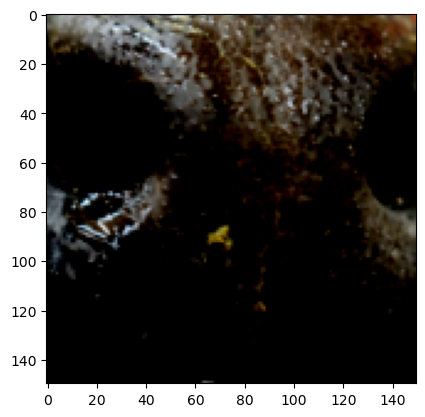

In [3]:
train_path='C:/Users/dell/Desktop/computervision25/basedata/train'
test_path='C:/Users/dell/Desktop/computervision25/basedata/validation'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)


img_path = 'C:/Users/dell/Desktop/computervision/cattle_0200_DSCF3871.jpg'
image = Image.open(img_path)
transformed_image = transformer(image)
transformed_image = transformed_image.numpy().transpose(1, 2, 0)
plt.imshow(transformed_image)
plt.show()


In [4]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['cattle_0100', 'cattle_0200', 'cattle_0300', 'cattle_0400', 'cattle_0500', 'cattle_0600', 'cattle_0700', 'cattle_0800', 'cattle_0900', 'cattle_1000', 'cattle_1100', 'cattle_1200', 'cattle_1300', 'cattle_1400', 'cattle_1500', 'cattle_1600', 'cattle_1700', 'cattle_1800', 'cattle_1900', 'cattle_2000', 'cattle_2100', 'cattle_2200', 'cattle_2220', 'cattle_2300', 'cattle_2320']


In [5]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=25):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=output.view(-1,32*75*75)
        output=self.fc(output)
        return output

In [6]:
model=ConvNet(num_classes=25).to(device)
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
num_epochs=20
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))
print(train_count,test_count)
best_accuracy=0.0

235 73


Epoch: 0 Train Loss: tensor(28.8218) Train Accuracy: 0.2680851063829787 Test Accuracy: 0.0821917808219178
Epoch: 1 Train Loss: tensor(18.7295) Train Accuracy: 0.5617021276595745 Test Accuracy: 0.0410958904109589
Epoch: 2 Train Loss: tensor(8.3326) Train Accuracy: 0.6723404255319149 Test Accuracy: 0.0410958904109589
Epoch: 3 Train Loss: tensor(3.1980) Train Accuracy: 0.8595744680851064 Test Accuracy: 0.0410958904109589
Epoch: 4 Train Loss: tensor(1.6375) Train Accuracy: 0.8851063829787233 Test Accuracy: 0.0410958904109589
Epoch: 5 Train Loss: tensor(1.1591) Train Accuracy: 0.9276595744680851 Test Accuracy: 0.0821917808219178
Epoch: 6 Train Loss: tensor(1.2875) Train Accuracy: 0.9617021276595744 Test Accuracy: 0.0821917808219178
Epoch: 7 Train Loss: tensor(0.1224) Train Accuracy: 0.9829787234042553 Test Accuracy: 0.0958904109589041
Epoch: 8 Train Loss: tensor(0.1898) Train Accuracy: 0.9829787234042553 Test Accuracy: 0.1232876712328767
Epoch: 9 Train Loss: tensor(0.0017) Train Accuracy: 1

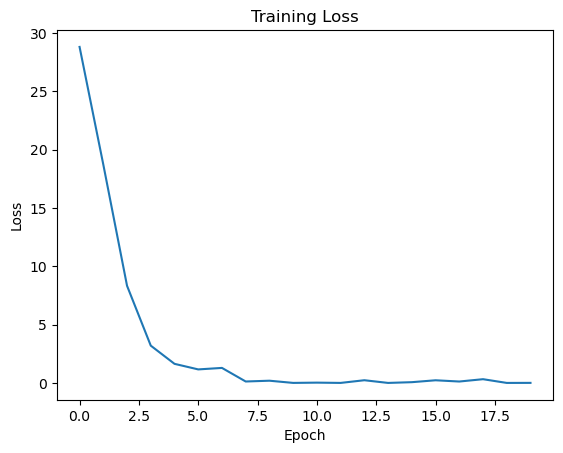

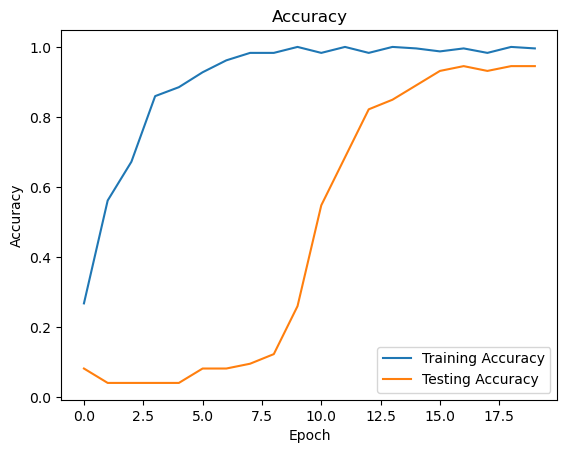

In [7]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    for i, (images,labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.data*images.size(0)
        _,prediction = torch.max(outputs.data,1)
        train_accuracy += int(torch.sum(prediction==labels.data))
    train_accuracy = train_accuracy/train_count
    train_loss = train_loss/train_count
    model.eval()
    
    test_accuracy = 0.0
    for i, (images,labels) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(images)
        _,prediction = torch.max(outputs.data,1)
        test_accuracy += int(torch.sum(prediction==labels.data))
    test_accuracy = test_accuracy/test_count
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy = test_accuracy
        
# Plot the training loss
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the training and testing accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

